In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
data_path_all = '../Data/lasI_without_hotspots.csv'
df_all = pd.read_csv(data_path_all)

# calculate the normalized fluo
df_all['fluo3'] = df_all['fluo2'] / df_all['fluo1']

In [3]:
# set plot sytle
sns.set(
    style='ticks', 
    context='talk', 
    palette='colorblind',
    rc={
        "axes.spines.top": False, 
        "axes.spines.right": False,
        "figure.figsize": (6, 6)
    }
)

## Calculate and Plot the Distribution of Rate of Intensity Change

In [4]:
# calculate the rate of change for each cell
for cluster in df_all['cluster'].unique():
    df_cluster = df_all[df_all['cluster'] == cluster]

    # calculate the rate of change
    df_all.loc[df_all['cluster'] == cluster, 'Rate'] = df_cluster.groupby('id')['fluo3'].apply(lambda x: x.diff() / x.shift()).reset_index(level=0, drop=True)
    
    # Calculate the threshold
    rate_values = df_all.loc[df_all['cluster'] == cluster, 'Rate'].dropna().abs()
    threshold = rate_values.mean() + 2 * rate_values.std()
    
    # annotate the hot spot
    df_all.loc[df_all['cluster'] == cluster, 'Hotspot_Rate'] = df_all.loc[df_all['cluster'] == cluster, 'Rate'].abs() > threshold

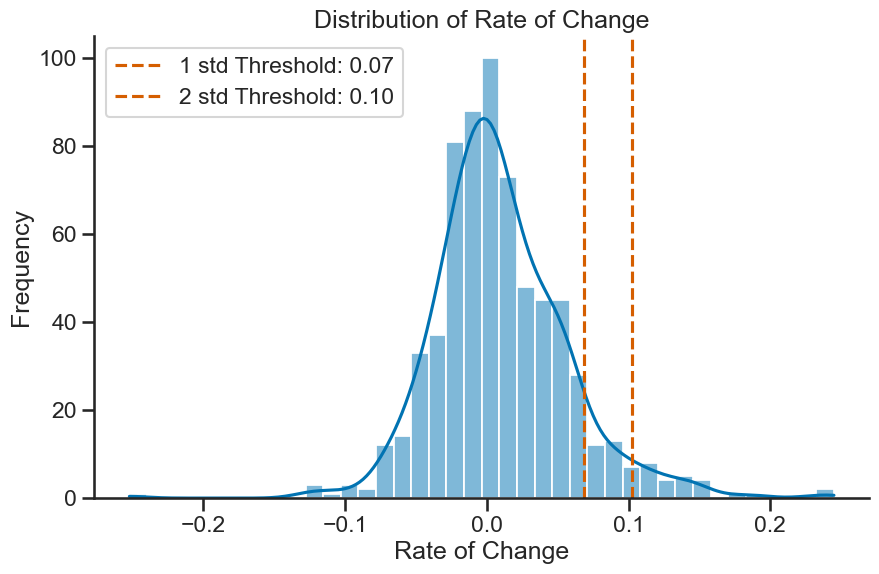

In [5]:
# look into the distribution one specific cluster
cluster_num = 78
df_test = df_all[df_all['cluster'] == cluster_num]

# calculate the rate of change
threshold = df_test['Rate'].abs().mean() + 1 * df_test['Rate'].abs().std()
threshold2 = df_test['Rate'].abs().mean() + 2 * df_test['Rate'].abs().std()

# plot the distribution plot of Rate
plt.figure(figsize=(10, 6))
sns.histplot(df_test['Rate'].dropna(), kde=True)
plt.xlabel('Rate of Change')
plt.ylabel('Frequency')
plt.title('Distribution of Rate of Change')
plt.axvline(threshold, color='r', linestyle='--', label=f'1 std Threshold: {threshold:.2f}')
plt.axvline(threshold2, color='r', linestyle='--', label=f'2 std Threshold: {threshold2:.2f}')
plt.legend()
plt.show()

## Plot the Distribution of Intensity

In [6]:
# plot the distribution plot of intensity
for cluster in df_all['cluster'].unique():
    df_cluster = df_all[df_all['cluster'] == cluster]

    # Calculate the threshold
    intensity_values = df_all.loc[df_all['cluster'] == cluster, 'fluo3'].dropna().abs()
    threshold = intensity_values.mean() + 2 * intensity_values.std()

    # calculate the rate of change
    df_all.loc[df_all['cluster'] == cluster, 'Hotspot_Intensity'] = df_all.loc[df_all['cluster'] == cluster, 'fluo3'].abs() > threshold

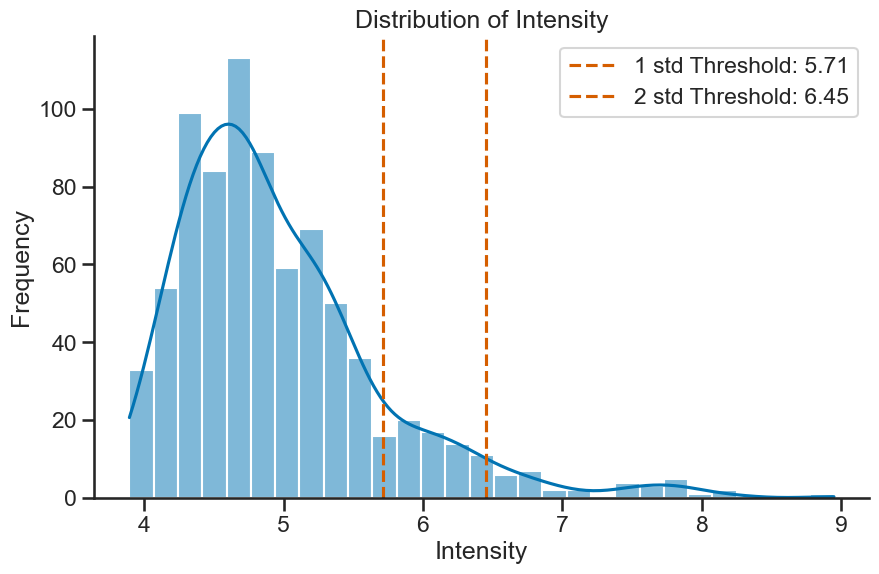

In [7]:
# look into the distribution one specific cluster
threshold_fluo = df_test['fluo3'].abs().mean() + 1 * df_test['fluo3'].abs().std()
threshold_fluo2 = df_test['fluo3'].abs().mean() + 2 * df_test['fluo3'].abs().std()

# plot the distribution plot of Rate
plt.figure(figsize=(10, 6))
sns.histplot(df_test['fluo3'].dropna(), kde=True)
plt.xlabel('Intensity')
plt.ylabel('Frequency')
plt.title('Distribution of Intensity')
plt.axvline(threshold_fluo, color='r', linestyle='--', label=f'1 std Threshold: {threshold_fluo:.2f}')
plt.axvline(threshold_fluo2, color='r', linestyle='--', label=f'2 std Threshold: {threshold_fluo2:.2f}')
plt.legend()
plt.show()

## Determine the interval for each cluster

In [9]:
# define the hot spot interval, and calculate the real hot spot, here is hour2 to hour6
df_interval = df_all[df_all['frames'].isin(range(8,25))].copy()
df_interval['Hotspot'] = df_interval['Hotspot_Rate'] | df_interval['Hotspot_Intensity']
df_interval['Real_Hotspot'] = df_interval.groupby(['cluster', 'id'])['Hotspot'].transform(lambda x: x.rolling(window=14, min_periods=1).max())

## Calculate Hotspot area

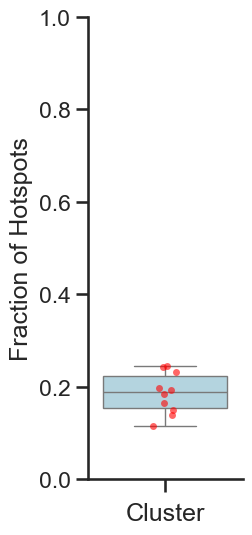

   cluster  Fraction
0       78  0.196262
1       79  0.191781
2       80  0.241935
3       81  0.244681
4       82  0.184615
5       83  0.150442
6       84  0.115702
7       85  0.230769
8       86  0.137931
9       87  0.163934


In [10]:
# calculate the fraction of hot spot
frame = 24

# Initialize an empty DataFrame
Fraction = []

for cluster in df_interval['cluster'].unique():
    df_cluster = df_interval[df_interval['cluster'] == cluster]
    
    df_cluster = df_cluster[df_cluster['frames'] == frame]
    hotspots = df_cluster[df_cluster['Real_Hotspot'] == 1]
    
    fraction_value = len(hotspots) / len(df_cluster) if len(df_cluster) > 0 else 0
    Fraction.append({'cluster': cluster, 'Fraction': fraction_value})

df_fraction = pd.DataFrame(Fraction)

plt.figure(figsize=(2, 6))
sns.boxplot(data=df_fraction.Fraction, color='lightblue', showfliers=False)
sns.stripplot(data=df_fraction.Fraction, color='red', jitter=True, dodge=True, alpha=0.6)
plt.xlabel('Cluster')
plt.ylabel('Fraction of Hotspots')
plt.ylim(0, 1)
# plt.title('Box Plot of Fraction of Hotspots per Cluster')
plt.show()

print(df_fraction)

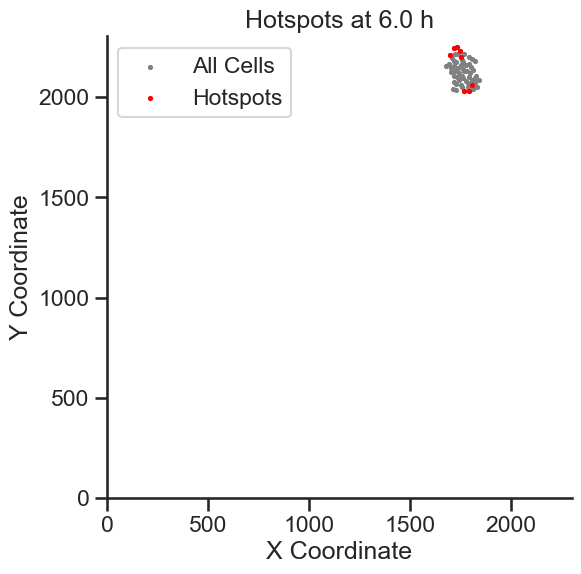

In [14]:
# Plot the area for hotspot
frame =24
df_plot = df_interval[(df_interval['frames'] == frame) & (df_interval['cluster'] == 86)].copy()
# extract the hotspot cells
hotspots = df_plot[df_plot['Real_Hotspot'] == 1]

plt.scatter(df_plot['new_x'], df_plot['new_y'], c='gray', label='All Cells', s=5, alpha=1)
plt.scatter(hotspots['new_x'], hotspots['new_y'], c='red', label='Hotspots', s=5, alpha=1)
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Hotspots at {} h'.format(frame*0.25))
plt.xlim(0, 2304)
plt.ylim(0, 2304)
plt.legend()
plt.show()

## Calculate the Lineage within Hotspot

In [15]:
def get_lineage(df, start_cid):
    """
    Recursively finds all cells in the lineage starting from the given cid.
    
    Args:
        df (pd.DataFrame): DataFrame containing the columns 'cid', 'did1', and 'did2'.
        start_cid (str): The starting cell ID to trace the lineage from.
    
    Returns:
        list: A list of all cids in the lineage.
    """
    lineage = set()  # Use a set to avoid duplicate entries

    def trace_lineage(cid):
        if pd.isna(cid) or cid in lineage:
            return
        lineage.add(cid)
        # Find the current cid's daughters
        daughters = df.loc[df['cid'] == cid, ['did1', 'did2']].values.flatten()
        # Recursively trace for both daughters
        for did in daughters:
            trace_lineage(did)

    # Start tracing from the given cid
    trace_lineage(start_cid)
    return list(lineage)

def extract_unique_cells(lineage):
    cells = [int(item.split('_')[0]) for item in lineage]
    cells_unique = set(cells)
    return cells_unique

# # Example Usage:
# lineage = get_lineage(df_86, '2_1')
# lineage_2 = get_lineage(df_86, '24_0')
# lineage = lineage + lineage_2
# print(lineage)

# unique = extract_unique_cells(lineage)
# unique_hotspot = [cid for cid in unique if cid in df_86[(df_86['frames'] == 20) & (df_86['Real_Hotspot'] == 1)].id.unique()]
# filtered_unique = [cell for cell in unique_hotspot if cell in df_86.id.unique()]
# print(len(filtered_unique))

In [16]:
# calculate the fraction of lineage in hot spot
lineage_Fraction = []

for cluster in df_interval['cluster'].unique():
    df_cluster = df_interval[df_interval['cluster'] == cluster]
    
    print(f'cluster: {cluster}')
    # define the first hotspot cell
    frame = df_cluster.loc[df_cluster['Real_Hotspot'] == 1, 'frames'].min()
    print(f'first frame with activated cells: {frame}')
    cell_ids = df_cluster.loc[(df_cluster['frames'] == frame) & (df_cluster['Real_Hotspot'] == 1), 'cid'].values
    print(f'cell counts: {len(cell_ids)}')
    
    lineage_hotspot = []
    for cell_id in cell_ids:
        lineage_cid = get_lineage(df_cluster, cell_id)
        # lineage_cid_hotspot = [cid for cid in lineage_cid if cid in df_cluster[(df_cluster['frames'] == 20) & (df_cluster['Real_Hotspot'] == 1)].cid.unique()]
        lineage_id = extract_unique_cells(lineage_cid)
        lineage_hotspot_id = [cell for cell in lineage_id if cell in df_cluster[(df_cluster['frames'] == 20) & (df_cluster['Real_Hotspot'] == 1)].id.unique()]
        
        # hotspots = df_cluster[(df_cluster['frames'] == frame) & (df_cluster['Real_Hotspot'] == 1)]
        # hotspots_filtered = hotspots[hotspots['id'].isin(filtered_unique)]
        lineage_hotspot.extend(lineage_hotspot_id)
    print(f'lineage_hotspot : {lineage_hotspot}')
        
    fraction_value = len(lineage_hotspot) / len(df_cluster[(df_cluster['frames'] == 20) & (df_cluster['Real_Hotspot'] == 1)])
    lineage_Fraction.append({'cluster': cluster, 'Fraction': fraction_value, 'Activated cell counts': len(cell_ids)})
    
    print(f'fraction : {fraction_value}', 
          '\n')
    
df_lineage_Fraction = pd.DataFrame(lineage_Fraction)

cluster: 78
first frame with activated cells: 12
cell counts: 3
lineage_hotspot : [7, 20, 60]
fraction : 0.25 

cluster: 79
first frame with activated cells: 8
cell counts: 4
lineage_hotspot : [1, 60, 21, 39, 41, 110]
fraction : 0.6666666666666666 

cluster: 80
first frame with activated cells: 12
cell counts: 1
lineage_hotspot : [46]
fraction : 0.25 

cluster: 81
first frame with activated cells: 9
cell counts: 2
lineage_hotspot : [131, 101, 22, 58, 35]
fraction : 0.5 

cluster: 82
first frame with activated cells: 14
cell counts: 1
lineage_hotspot : [28]
fraction : 0.3333333333333333 

cluster: 83
first frame with activated cells: 8
cell counts: 2
lineage_hotspot : [4, 61, 108, 111, 22, 63]
fraction : 0.6666666666666666 

cluster: 84
first frame with activated cells: 8
cell counts: 1
lineage_hotspot : [8, 64]
fraction : 0.16666666666666666 

cluster: 85
first frame with activated cells: 9
cell counts: 1
lineage_hotspot : [12, 141]
fraction : 0.4 

cluster: 86
first frame with activat

In [ ]:
df_lineage_Fraction.mean()

,cluster,Fraction,Activated cell counts
0,78,0.250000,3
1,79,0.666667,4
2,80,0.250000,1
3,81,0.500000,2
4,82,0.333333,1
5,83,0.666667,2
6,84,0.166667,1
7,85,0.400000,1
8,86,0.666667,3
9,87,0.375000,2


In [19]:
df_lineage_Fraction['Initial Activated Cells'] = df_lineage_Fraction['Activated cell counts'].apply(lambda x: 1 if x == 1 else '>1')
df_lineage_Fraction

,cluster,Fraction,Activated cell counts,Initial Activated Cells
0,78,0.250000,3,>1
1,79,0.666667,4,>1
2,80,0.250000,1,1
3,81,0.500000,2,>1
4,82,0.333333,1,1
5,83,0.666667,2,>1
6,84,0.166667,1,1
7,85,0.400000,1,1
8,86,0.666667,3,>1
9,87,0.375000,2,>1


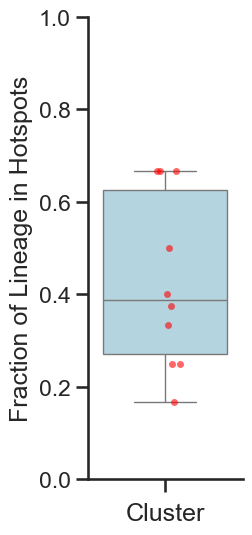

In [ ]:
# plot the fraction of lineage in hot spot
plt.figure(figsize=(2, 6))
sns.boxplot(data=df_lineage_Fraction.Fraction, color='lightblue', showfliers=False)
sns.stripplot(data=df_lineage_Fraction.Fraction, color='red', jitter=True, dodge=True, alpha=0.6)
plt.xlabel('Cluster')
plt.ylabel('Fraction of Lineage in Hotspots')
plt.ylim(0, 1)
# plt.title('Box Plot of Fraction of Hotspots per Cluster')
plt.show()

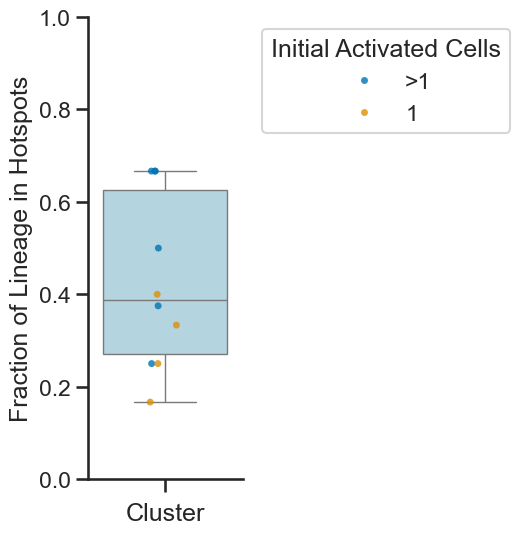

In [ ]:
# Plot the fraction of lineage in hot spot, coloring by the number of initial activated cells
plt.figure(figsize=(2, 6))
sns.boxplot(data=df_lineage_Fraction, y='Fraction', color='lightblue', showfliers=False)

# Add scatter plot for clusters, coloring by InitialActivatedCells
sns.stripplot(
    data=df_lineage_Fraction,
    y='Fraction',
    #x=0,  # Dummy x-axis to align dots with boxplot
    hue='Initial Activated Cells',  # Color dots by InitialActivatedCells
    jitter=True,  # Add jitter for better visibility
    alpha=0.8,  # Adjust dot transparency
    dodge=False  # No need to dodge since x-axis is fixed
)

# Adjust the legend
plt.legend(title='Initial Activated Cells', bbox_to_anchor=(1.05, 1), loc='upper left')

# Set labels and limits
plt.xlabel('Cluster')
plt.ylabel('Fraction of Lineage in Hotspots')
plt.ylim(0, 1)

# Show the plot
plt.show()